In [1]:
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("../utility")
sys.path.append("../scripts")
from train import koopman_rollout_loss
from inference import load_koopman_model, recover_single_control, predict_next_state
import matplotlib.pyplot as plt


env_name = 'G1CartPole'
u_dim, state_dim = 7, 16
dataset = torch.load(f'../data/datasets/dataset_{env_name}_unnorm_train_80000_val_10000_test_10000_steps_20.pt',
                     weights_only=False)
test_data = dataset["test_data"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = load_koopman_model(f"../log/best_models/G1/best_model_{env_name}.pth",
                         state_dim, u_dim, device)
mse_loss = nn.MSELoss()
gamma = 1.0


traj_idx = np.random.randint(0, test_data.shape[1])
t0       = np.random.randint(0, test_data.shape[0] - 1)

data_pair = torch.from_numpy(
    test_data[:, traj_idx:traj_idx+1, :]
).float().to(device)

total_loss, state_loss, control_loss, encoding0 = koopman_rollout_loss(
    data_pair, net, mse_loss, u_dim, gamma, device,
    control_loss_weight=1.0
)

print(f"roll out state‐loss:   {state_loss.item():.4e}")
print(f"roll out control‐loss: {control_loss.item():.4e}")

dp = data_pair.squeeze(1).cpu().numpy()
T = dp.shape[0]                           # 10
u_true_seq = dp[:-1, :u_dim]              # shape (9, 7)
x_states   = dp[:,   u_dim:]              # shape (10,16)

# 1) initial latent encoding from x₀
X_curr = net.encode(torch.from_numpy(x_states[0]).to(device))

u_rec_list  = []
x_pred_list = []

# 2) loop over all 9 transitions
for k in range(T-1):                      # k = 0..8
    # recover the control from the *true* states x_k → x_{k+1}
    u_rec = recover_single_control(
        x_states[k],
        x_states[k+1],
        net,
        device
    )
    u_rec_list.append(u_rec.cpu().numpy())

    # propagate the latent state with the *ground‐truth* u_k
    X_curr = net.forward(
        X_curr,
        torch.from_numpy(u_true_seq[k]).to(device)
    )
    # extract the first `state_dim` entries as the predicted x_{k+1}
    x_pred = X_curr[:state_dim].detach().cpu().numpy()
    x_pred_list.append(x_pred)

# stack into arrays of shape (9, …)
u_rec_seq  = np.stack(u_rec_list)
x_pred_seq = np.stack(x_pred_list)

# 3) compute the two MSEs
state_mse   = np.mean((x_pred_seq   - x_states[1:])**2)
control_mse = np.mean((u_rec_seq    - u_true_seq )**2)

print(f"manual rollout state loss:   {state_mse:.4e}")
print(f"manual rollout control loss: {control_mse:.4e}")

Checkpoint keys: dict_keys(['model', 'layer'])
roll out state‐loss:   4.4380e+01
roll out control‐loss: 1.3869e+02
manual rollout state loss:   4.4380e+01
manual rollout control loss: 1.3869e+02


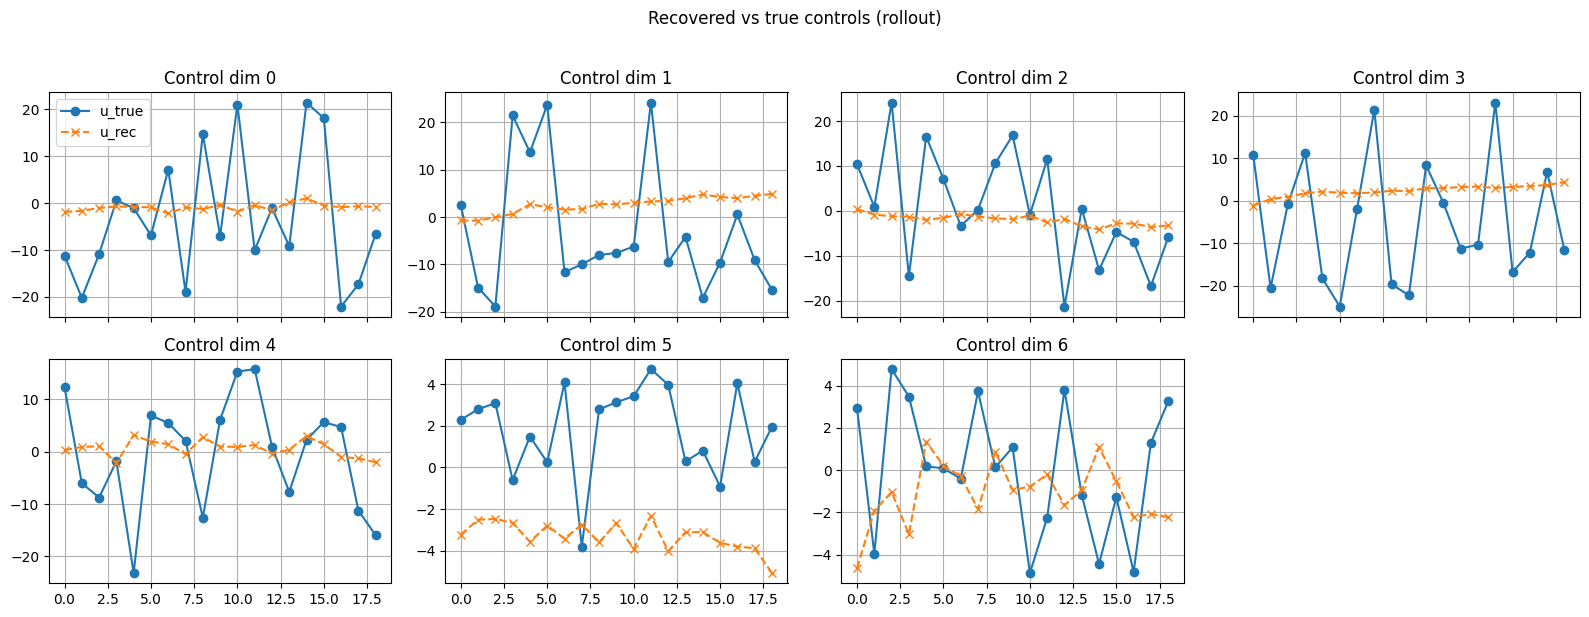

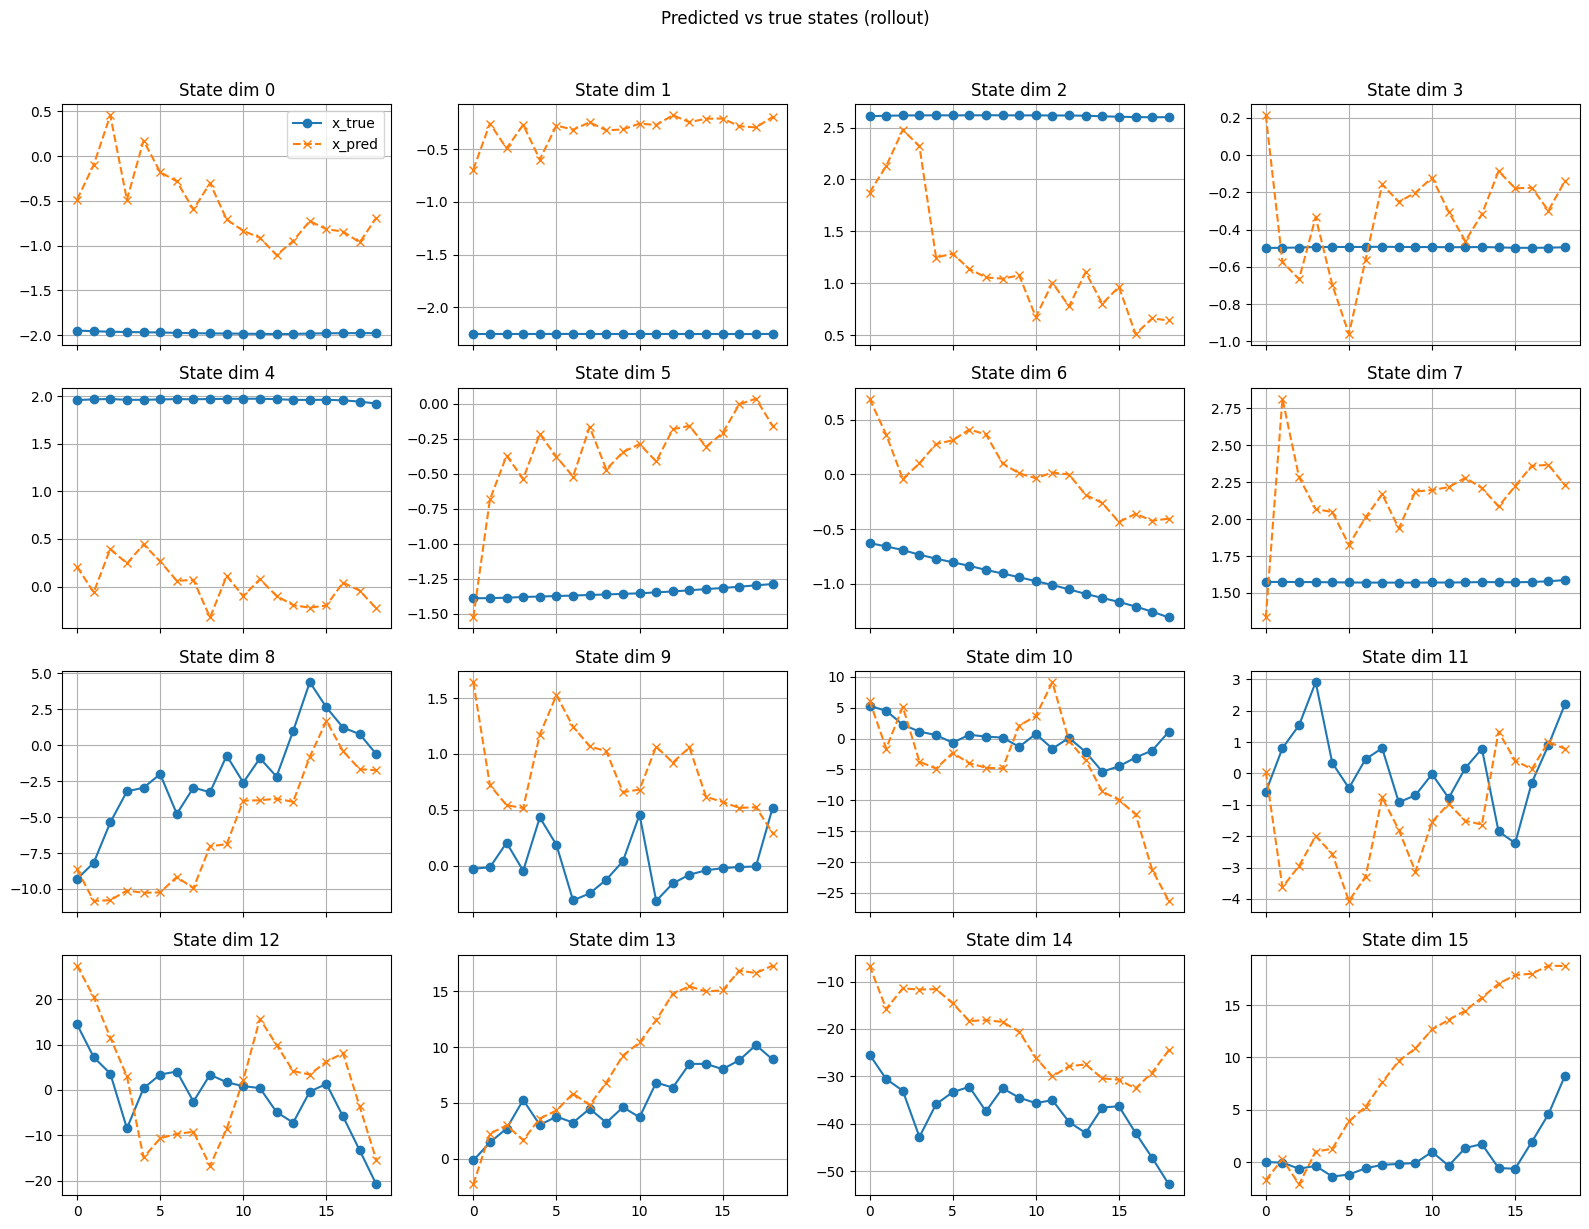

In [3]:
time = np.arange(T-1)  # 0..8
# controls:
n_cols = 4
n_rows = int(np.ceil(u_dim / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,3*n_rows), sharex=True)
for i, ax in enumerate(axes.flatten()):
    if i < u_dim:
        ax.plot(time, u_true_seq[:,i],  'o-',  label='u_true')
        ax.plot(time, u_rec_seq[:, i], 'x--', label='u_rec')
        ax.set_title(f'Control dim {i}')
        ax.grid(True)
        if i==0: ax.legend()
    else:
        ax.axis('off')
fig.suptitle("Recovered vs true controls (rollout)", y=1.02)
plt.tight_layout()

# states:
n_cols = 4
n_rows = int(np.ceil(state_dim / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,3*n_rows), sharex=True)
for i, ax in enumerate(axes.flatten()):
    if i < state_dim:
        ax.plot(time, x_states[1:,i],  'o-',  label='x_true')
        ax.plot(time, x_pred_seq[:, i], 'x--', label='x_pred')
        ax.set_title(f'State dim {i}')
        ax.grid(True)
        if i==0: ax.legend()
    else:
        ax.axis('off')
fig.suptitle("Predicted vs true states (rollout)", y=1.02)
plt.tight_layout()
plt.show()

In [52]:
raw_data = np.load(f"../data/datasets/g1_cartpole_data/g1_cartpole_20_step_100_traj_0.001_dtctrl.npy")
raw_data.shape

(20, 100, 23)

In [55]:
raw_data[10:,32,7:]

array([[  0.45490103,   0.16993854,   0.81107504,  -0.75923296,
          1.76699837,  -0.57369988,  -0.33702692,   1.62094237,
         -8.72787014, -15.40411674,  16.09400411,  27.61437602,
        -17.27936911,   8.38786697,   7.30680925, -14.78190464],
       [  0.44532216,   0.1550421 ,   0.82752167,  -0.73122182,
          1.74961778,  -0.56610898,  -0.33107001,   1.60659955,
         -9.57887193, -14.89644047,  16.4466294 ,  28.01113749,
        -17.38058933,   7.59089775,   5.95690542, -14.34281852],
       [  0.43574932,   0.14096061,   0.84209582,  -0.70516026,
          1.74082142,  -0.55652462,  -0.32570636,   1.58965155,
         -9.57283655, -14.08148615,  14.57415887,  26.06156017,
         -8.7963618 ,   9.58435918,   5.36365668, -16.94800291],
       [  0.42520286,   0.12743854,   0.85854785,  -0.67850567,
          1.72377611,  -0.54988734,  -0.32292766,   1.57982484,
        -10.54646396, -13.52207209,  16.45202376,  26.65459221,
        -17.04530794,   6.6372871 ,  

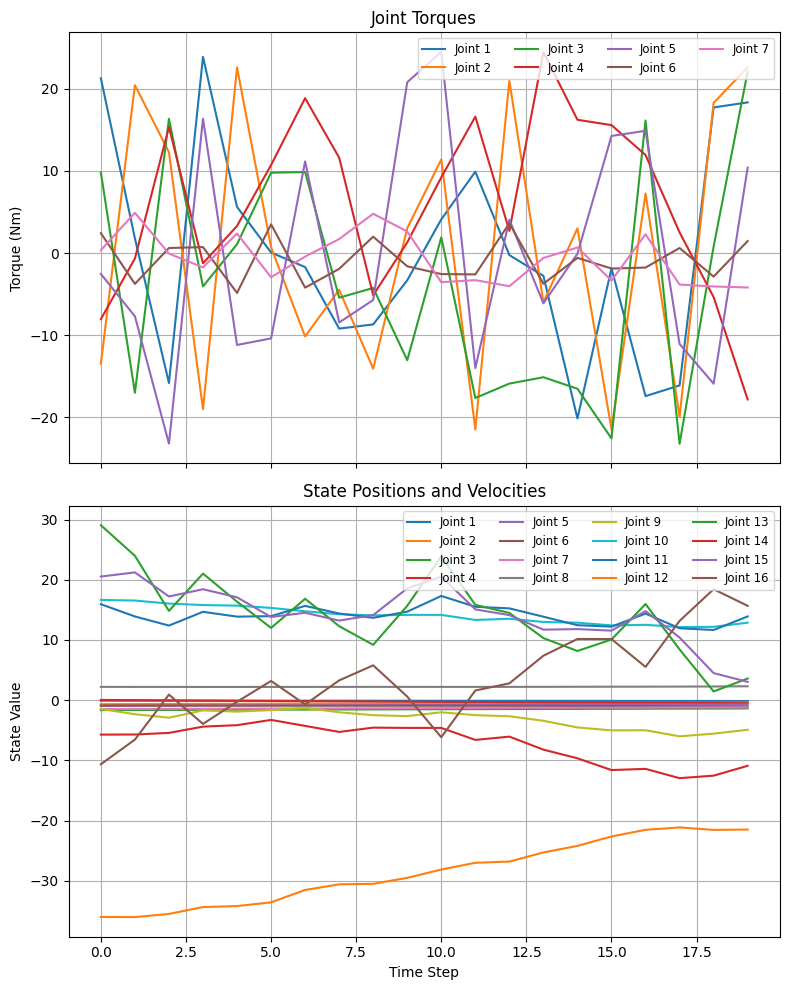

In [61]:
random_idx = np.random.randint(0, raw_data.shape[1])
torque_data = raw_data[:, random_idx, :].reshape(-1, 23)[:, :7]
state_data = raw_data[:, random_idx, :].reshape(-1, 23)[:, 7:]

fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)



# Plot torques
for i in range(7):
    axs[0].plot(torque_data[:, i], label=f'Joint {i+1}')
axs[0].set_title('Joint Torques')
axs[0].set_ylabel('Torque (Nm)')
axs[0].legend(loc='upper right', ncol=4, fontsize='small')
axs[0].grid(True)

# Plot velocities
for i in range(16):
    axs[1].plot(state_data[:, i], label=f'Joint {i+1}')
axs[1].set_title('State Positions and Velocities') 
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('State Value')
axs[1].legend(loc='upper right', ncol=4, fontsize='small')
axs[1].grid(True)
plt.tight_layout()
plt.show()